# Day by day analysis

In [1]:
from elasticsearch import Elasticsearch
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import os
from time import gmtime, strftime


### Cart stuff

In [2]:
savedgraphpath = './data/graphs/{0}'.format(strftime("%Y-%m-%d_%H:%M:%S", gmtime()))
os.makedirs(savedgraphpath)

In [3]:
# Delta between today and february the 25th
start = datetime.date(2017, 2, 25)
delta = datetime.date.today() - start
delta_day = delta.days
# delta_day = 13
print(delta_day)

client = Elasticsearch(hosts='172.16.0.11:9200')
body = """{
  "query": {
    "bool": {
      "must": [
        {
          "term": {
            "site_id": {
              "value": "1626"
            }
          }
        },
        {
          "range": {
            "created": {
              "gte": "now-"""+str(delta_day)+"""d/d",
              "lte": "now"
            }
          }
        },
        {
          "term": {
            "action": {
              "value": "itemadded"
            }
          }
        }
      ]
    }
  }, 
  "aggs": {
    "groups": {
      "terms": {
        "field": "sampler_abgroup",
        "size": 10
      },
      "aggs": {
        "dates": {
          "date_histogram": {
            "field": "created",
            "interval": "day"
          }
        }
      }
    }
  }
}"""
index = 'events'
response = client.search(index=index, 
                      body = body)

32


In [4]:
cart_by_day = []
for group in response['aggregations']['groups']['buckets']:
    for date in group['dates']['buckets']:
        cart_by_day.append([date['key_as_string'],
                           group['key'],
                           date['doc_count']])

In [5]:
df_itemadded = pd.DataFrame(cart_by_day, columns=['date', 'group', 'itemadded'])
df_itemadded.head()
df_itemadded.set_index(['date']);

In [6]:
df_itemaddedA = df_itemadded[df_itemadded.group == 'a']
df_itemaddedB = df_itemadded[df_itemadded.group == 'b']
df_itemaddedA = df_itemaddedA.set_index(['date'])
df_itemaddedB = df_itemaddedB.set_index(['date'])
df = pd.concat([df_itemaddedA,
                df_itemaddedB],
                axis = 1,)
df.columns = ['gra', 'A', 'grb', 'B']
df = df.drop(['gra', 'grb'], axis=1)

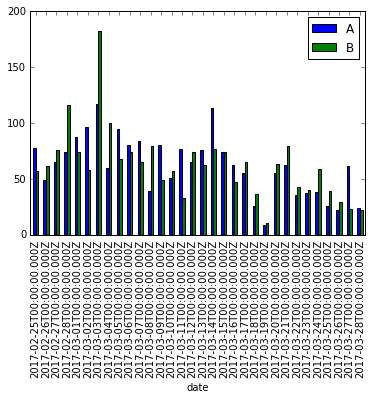

In [7]:
%matplotlib inline
fig = df.plot.bar()
plt.savefig('{0}/itemadded.png'.format(savedgraphpath))

In [8]:
print("A ajoute plus d'item au panier que B {0} jours sur {1}"\
      .format(len(df[df.A > df.B]),len(df)))


A ajoute plus d'item au panier que B 13 jours sur 32


### Page visit stuff

In [9]:
body_visit="""{
  "query": {
    "bool": {
      "must": [
        {
          "term": {
            "site_id": {
              "value": "1626"
            }
          }
        },
        {
          "range": {
            "created": {
              "gte": "now-"""+str(delta_day)+"""d/d",
              "lte": "now"
            }
          }
        },
        {
          "term": {
            "event_name": {
              "value": "page_visit"
            }
          }
        }
      ]
    }
  },
  "aggs": {
    "group": {
      "terms": {
        "field": "sampler_abgroup",
        "size": 10
      },
      "aggs": {
        "dates": {
          "date_histogram": {
            "field": "created",
            "interval": "day"
          }
        }
      }
    }
  }
}"""
index = 'events'
response_visit = client.search(index=index, 
                      body = body_visit)

page_visit_by_day = []
for group in response_visit['aggregations']['group']['buckets']:
    for date in group['dates']['buckets']:
        page_visit_by_day.append([date['key_as_string'],
                           group['key'],
                           date['doc_count']])
        
        

In [10]:
df_page_visit = pd.DataFrame(page_visit_by_day, columns=['date', 'group', 'page_visit'])
df_page_visit.head()
df_page_visit.set_index(['date']);
df_page_visitA = df_page_visit[df_page_visit.group == 'a']
df_page_visitB = df_page_visit[df_page_visit.group == 'b']
df_page_visitA = df_page_visitA.set_index(['date'])
df_page_visitB = df_page_visitB.set_index(['date'])
df_pageByDay = pd.concat([df_page_visitA,
                df_page_visitB],
                axis = 1,)
df_pageByDay.columns = ['gra', 'A', 'grb', 'B']
df_pageByDay = df_pageByDay.drop(['gra', 'grb'], axis=1)

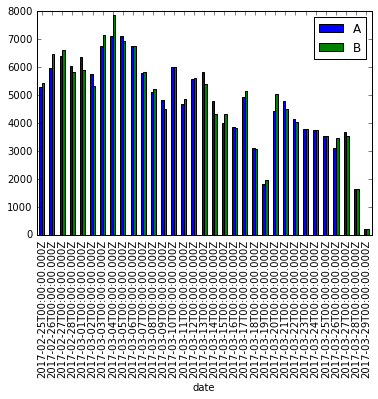

In [11]:
%matplotlib inline
fig_visit = df_pageByDay.plot.bar()
plt.savefig('./data/page_visited.png')

In [12]:
print("A voit plus de pages que B {0} jours sur {1}"\
      .format(len(df_pageByDay[df_pageByDay.A > df_pageByDay.B]),len(df_pageByDay)))


A voit plus de pages que B 18 jours sur 33


### order	stuff

In [13]:
client = Elasticsearch(hosts='172.16.0.11:9200')

body_visit="""{
  "query": {
    "bool": {
      "must": [
        {
          "term": {
            "site_id": {
              "value": "1626"
            }
          }
        },
        {
          "range": {
            "record_date": {
              "gte": "now-"""+str(delta_day)+"""d/d",
              "lte": "now"
            }
          }
        },
        {
          "term": {
            "is_cancelled": {
              "value": "false"
            }
          }
        }
      ]
    }
  }, 
  "aggs": {
    "groups": {
      "terms": {
        "field": "sampler_abgroup",
        "size": 10
      },
      "aggs": {
        "dates": {
          "date_histogram": {
            "field": "record_date",
            "interval": "day"
          }
        }
      }
    }
  }
}"""
index_order = 'orders'
response_order = client.search(index=index_order, 
                      body = body_visit)

orders_by_day = []
for group in response_order['aggregations']['groups']['buckets']:
    for date in group['dates']['buckets']:
        orders_by_day.append([date['key_as_string'],
                           group['key'],
                           date['doc_count']])
        
        

In [14]:
df_orders = pd.DataFrame(orders_by_day, columns=['date', 'group', 'page_visit'])
df_orders.head()
df_orders.set_index(['date']);
df_ordersA = df_orders[df_orders.group == 'a']
df_ordersB = df_orders[df_orders.group == 'b']
df_ordersA = df_ordersA.set_index(['date'])
df_ordersB = df_ordersB.set_index(['date'])
df_OrdersByDay = pd.concat([df_ordersA,
                df_ordersB],
                axis = 1,)
df_OrdersByDay.columns = ['gra', 'A', 'grb', 'B']
df_OrdersByDay = df_OrdersByDay.drop(['gra', 'grb'], axis=1)


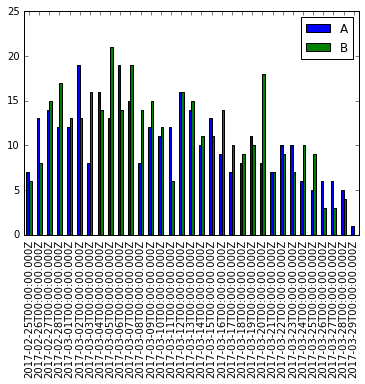

In [15]:
# %matplotlib inline
fig_visit = df_OrdersByDay.plot.bar()
plt.savefig('./data/orders.png')

In [16]:
print("A fait plus d'orders que B {0} jours sur {1}"\
      .format(len(df_OrdersByDay[df_OrdersByDay.A > df_OrdersByDay.B]),len(df_OrdersByDay)))


A fait plus d'orders que B 13 jours sur 33


### Pognon stuff

In [17]:
client = Elasticsearch(hosts='172.16.0.11:9200')

index = 'orders'
body = """{
  "query": {
    "bool": {
      "must": [
        {
          "term": {
            "site_id": {
              "value": "1626"
            }
          }
        },
        {
          "range": {
            "record_date": {
              "gte": "now-"""+str(delta_day)+"""d/d",
              "lte": "now"
            }
          }
        },
        {
          "term": {
            "is_cancelled": {
              "value": "false"
            }
          }
        }
      ]
    }
  }, 
  "aggs": {
    "groups": {
      "terms": {
        "field": "sampler_abgroup",
        "size": 10
      },
      "aggs": {
        "dates": {
          "date_histogram": {
            "field": "record_date",
            "interval": "day"
          },
          "aggs": {
            "sum": {
              "sum": {
                "field": "total_wo_tax"
              }
            }
          }
        }
      }
    }
  }
}"""
response = client.search(index=index, 
                      body = body)
total_day = []
for group in response['aggregations']['groups']['buckets']:
    for date in group['dates']['buckets']:
        total_day.append([date['key_as_string'],
                           group['key'],
                           date['sum']['value']])
        
df_total = pd.DataFrame(total_day, columns=['date', 'group', 'CA'])
df_total.head()
df_total.set_index(['date']);
df_totalA = df_total[df_total.group == 'a']
df_totalB = df_total[df_total.group == 'b']
df_totalA = df_totalA.set_index(['date'])
df_totalB = df_totalB.set_index(['date'])
df_TotalByDay = pd.concat([df_totalA,
                df_totalB],
                axis = 1,)
df_TotalByDay.columns = ['gra', 'A', 'grb', 'B']
df_TotalByDay = df_TotalByDay.drop(['gra', 'grb'], axis=1)

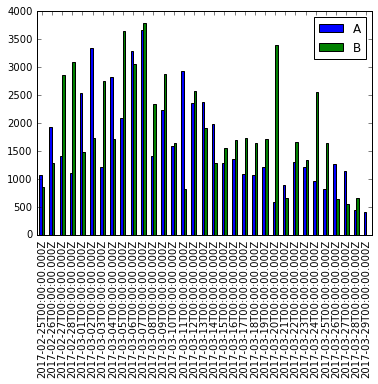

In [18]:
fig_visit = df_TotalByDay.plot.bar()
plt.savefig('./data/total_wo_tax.png')

In [19]:
print("A fait plus de chiffre que B {0} jours sur {1}"\
      .format(len(df_TotalByDay[df_TotalByDay.A > df_TotalByDay.B]),len(df_TotalByDay)))


A fait plus de chiffre que B 12 jours sur 33
